# This jupyter notebook is used to train model for SI platform


In [1]:

import collections
import tqdm
import os
import sys

import logging
import requests
from itertools import chain

# from django.core.management.base import BaseCommand

import joblib
import json
from datetime import datetime
import spacy

from nltk.corpus import stopwords

logger = logging.getLogger(__name__)

import numpy as np
import pandas as pd
import string

punc = string.punctuation

stop_words = set(stopwords.words('english'))

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

In [3]:
import sklearn

In [4]:
# import pprint, sklearn
# pprint.pprint(sklearn.__file__)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

HEADERS ={
        'TOKEN': "963c10dc79a568bf18341fb6e8e73275",
        'INDEX': "si_story",
        'Content-Type': 'application/json',
        'Accept': 'application/json'
        }

In [7]:
from ast import literal_eval

In [8]:
import pandas as pd
import glob
import os

In [9]:
# all_files = glob.glob(os.path.join('./topics_data_2_year/', "*.csv"))

# df = 
df = pd.read_csv('be_data.csv')

In [10]:
df

,Unnamed: 0,Title,Intro,Business Events,URL,titles,body,correct BE,UUID
0,0,Call to artists for local innovation lab with ...,A local county has put out a call to artists a...,R&D Labs/ Innovation Centers,https://www.orlando-news.com/2023/11/01/call-t...,Call to artists for local innovation lab with ...,A local county has put out a call to artists a...,"[2, 13]",1-82-231101-54258124
1,1,Condition-Adaptive EMI Control For EV’s,Home Projects (DIY) All Electronics Projects C...,R&D Labs/ Innovation Centers,https://www.electronicsforu.com/news/whats-new...,Condition-Adaptive EMI Control For EV’s,<p>Home </p> <p> Projects (DIY) </p> <p> </p> ...,"[2, 13]",1-82-231101-54256964
2,2,Virpax Pharmaceuticals Announces that Envelta™...,"BERWYN, Pa.--(BUSINESS WIRE)--Oct 31, 2023-- V...",R&D Labs/ Innovation Centers,https://www.bakersfield.com/ap/news/virpax-pha...,Virpax Pharmaceuticals Announces that Envelta™...,<p>\r\n \r\n ...,"[2, 13]",1-82-231101-54188210
3,3,Wireless device makes magnetism appear in non-...,Researchers at the Universitat Autònoma de Bar...,R&D Labs/ Innovation Centers,https://sortiwa.com/wireless-device-makes-magn...,Wireless device makes magnetism appear in non-...,Researchers at the Universitat Autònoma de Bar...,"[2, 13]",1-82-231101-54217356
4,4,IIT Madras develops aerogel adsorbent to remov...,Researchers from the Indian Institute of Techn...,R&D Labs/ Innovation Centers,https://www.indiatoday.in/education-today/news...,IIT Madras develops aerogel adsorbent to remov...,Researchers from the Indian Institute of Techn...,"[2, 13]",1-82-231101-54196627
...,...,...,...,...,...,...,...,...,...
7840,7840,Amazon Web Services,Many of today’s biggest household names began ...,Rebranding,https://abcnews4.com/lowcountry-live/amazon-we...,Amazon Web Services,Many of today’s biggest household names began ...,"[40, 43]",1-82-231101-54273374
7841,7841,"Supplier Manager in Montrose, United Kingdom",Site Name: UK - Angus - Montrose Posted Date: ...,Rebranding,https://jobs.gsk.com/en-gb/jobs/383263,"Supplier Manager in Montrose, United Kingdom",<strong>Site Name:</strong> UK - Angus - Montr...,"[40, 43]",1-82-231101-54247005
7842,7842,East Nashville building to be transformed into...,East Nashville building to be transformed into...,Rebranding,https://www.bizjournals.com/nashville/news/202...,East Nashville building to be transformed into...,<p>East Nashville building to be transformed i...,"[40, 43]",1-82-231102-54357420
7843,7843,Sailun TerraMax RT: The Drive ’Em in the Deser...,"What Is an RT Tire? First, what is an RT tire?...",Rebranding,https://www.motortrend.com/reviews/sailun-terr...,Sailun TerraMax RT: The Drive ’Em in the Deser...,"What Is an RT Tire?<br><br>First, what is an R...","[40, 43]",1-82-231102-54361574


In [11]:
new_be = {'Strategy': 2,
 'Business Closure': 3,
 'Business Expansion': 4,
 'Business Reorganisation / Restructuring': 5,
 'Demerger/Spin Off': 6,
 'Leadership Changes': 7,
 'M&A Activities': 8,
 'Asset Buy/ Divestiture': 9,
 'Funding Activities': 10,
 'Capital Investment': 11,
 'Joint Ventures': 12,
 'Partnerships and Alliances': 14,
 'R&D Labs/ Innovation Centers': 13,
 'Marketing': 40,
 'Marketing & Promotional Activities': 41,
 'Awards & Recognitions': 42,
 'Rebranding': 43,
 'HR & People': 44,
 'Hirings (Non-Leadership)': 45,
 'Layoff': 46,
 'Employee Related Initiative': 47,
 'Operations': 15,
 'Operational Performance': 16,
 'Cost Cutting': 17,
 'Supply Chain/ Procurement': 18,
 'Operational Challenges': 19,
 'Facility/Office Closure': 20,
 'Digital Transformation Initiative': 21,
 'Sales': 37,
 'Tender/ Contract Updates': 38,
 'Pricing Changes': 39,
 'Product Discontinuation': 36,
 'Products/Services': 31,
 'Product Issues/ Recall': 32,
 'Analyst Recognition': 33,
 'Product/Service Enhancement': 34,
 'New Product/Service': 35,
 'Financial': 22,
 'Accounting Fraud': 23,
 'Activist Shareholder': 24,
 'Bankruptcy': 25,
 'Credit Rating Update': 26,
 'Financial Performance': 27,
 'Insider Trading': 28,
 'IPO': 29,
 'Share Repurchase': 30,
 'Risk & Regulatory': 48,
 'Cybersecurity Incidents': 49,
 'Data Breach': 50,
 'Negative News': 51,
 'Lawsuit/ Legal Issue': 52,
 'Regulation and Policies': 53,
 'Regulatory Action/ Probe': 54,
 'Patent Dispute': 55,
 'Patent Filing': 56}

In [12]:
df = df.fillna(' ')

In [13]:
df['s_tags'] = df['Business Events'].apply(lambda x: [new_be[tag] for tag in x.split(' | ')] if pd.notnull(x) and '|' in str(x) else [new_be.get(x, x)])

In [14]:
filtered_df = df[df['s_tags'].apply(lambda x: x == [' '])]

In [15]:
len(df)

7845

In [16]:
df = df[~df['s_tags'].isin([[3, 2], [' ']])]

In [17]:
df = df[~df['s_tags'].isin([[3, 2], ['N']])]

In [18]:
# if 'Business Events' in df.columns:
#     df['s_tags'] = df['Business Events'].map(new_be).apply(lambda x: f'[{int(x)}]' if pd.notnull(x) else None)

In [19]:
len(df)

7831

# Preprocessing and visualisation of data of Data

In [20]:
# df['s_tags'] = df.s_tags.apply(lambda x: [int(j.strip()) for j in x[1:-1].split(',') if j != ''])
    

In [21]:
# for i in df['s_tags']:
# #     print(type(i))
#     temp_lis = []
#     for j in i:
#         if j != '':
#             temp_lis.append(int(j.strip()))
#     df['s_tags'][i] = temp_lisj

In [22]:
# df.to_csv("Contify Industry News top 10 tags.csv", index="True", header="True")


In [23]:
df.head(3)

,Unnamed: 0,Title,Intro,Business Events,URL,titles,body,correct BE,UUID,s_tags
0,0,Call to artists for local innovation lab with ...,A local county has put out a call to artists a...,R&D Labs/ Innovation Centers,https://www.orlando-news.com/2023/11/01/call-t...,Call to artists for local innovation lab with ...,A local county has put out a call to artists a...,"[2, 13]",1-82-231101-54258124,[13]
1,1,Condition-Adaptive EMI Control For EV’s,Home Projects (DIY) All Electronics Projects C...,R&D Labs/ Innovation Centers,https://www.electronicsforu.com/news/whats-new...,Condition-Adaptive EMI Control For EV’s,<p>Home </p> <p> Projects (DIY) </p> <p> </p> ...,"[2, 13]",1-82-231101-54256964,[13]
2,2,Virpax Pharmaceuticals Announces that Envelta™...,"BERWYN, Pa.--(BUSINESS WIRE)--Oct 31, 2023-- V...",R&D Labs/ Innovation Centers,https://www.bakersfield.com/ap/news/virpax-pha...,Virpax Pharmaceuticals Announces that Envelta™...,<p>\r\n \r\n ...,"[2, 13]",1-82-231101-54188210,[13]


In [24]:
df = df.fillna(' ')

In [25]:
tag_list = df['s_tags'].to_list()
all_tag_list = list(chain.from_iterable(tag_list))
# all_tag_list = [i.strip() for i in all_tag_list]
tag_count = collections.Counter(all_tag_list)
del all_tag_list, tag_list

In [26]:
# exclude_parent = [387,395]

In [27]:
# tag_count = {k:v for k,v in tag_count.items() if k not in exclude_parent}

In [28]:
# del tag_count['N']

In [29]:
# tag_count = {int(i):j for i,j in tag_count.items()}

In [30]:
tag_count

Counter({13: 200,
         15: 12,
         49: 3,
         31: 8,
         4: 226,
         11: 681,
         14: 231,
         12: 592,
         9: 208,
         10: 200,
         29: 26,
         7: 626,
         18: 4,
         5: 759,
         21: 2,
         6: 620,
         46: 10,
         44: 3,
         8: 577,
         52: 7,
         43: 240,
         38: 2,
         22: 5,
         20: 668,
         3: 681,
         17: 1,
         24: 623,
         27: 636,
         23: 205,
         54: 3,
         41: 702,
         48: 9,
         28: 2,
         37: 3})

In [31]:
# del tag_count[' ']

In [32]:
id_name_map = {2: 'Strategy',
 3: 'Business Closure',
 4: 'Business Expansion',
 5: 'Business Reorganisation / Restructuring',
 6: 'Demerger/Spin Off',
 7: 'Leadership Changes',
 8: 'M&A Activities',
 9: 'Asset Buy/ Divestiture',
 10: 'Funding Activities',
 11: 'Capital Investment',
 12: 'Joint Ventures',
 14: 'Partnerships and Alliances',
 13: 'R&D Labs/ Innovation Centers',
 40: 'Marketing',
 41: 'Marketing & Promotional Activities',
 42: 'Awards & Recognitions',
 43: 'Rebranding',
 44: 'HR & People',
 45: 'Hirings (Non-Leadership)',
 46: 'Layoff',
 47: 'Employee Related Initiative',
 15: 'Operations',
 16: 'Operational Performance',
 17: 'Cost Cutting',
 18: 'Supply Chain/ Procurement',
 19: 'Operational Challenges',
 20: 'Facility/Office Closure',
 21: 'Digital Transformation Initiative',
 37: 'Sales',
 38: 'Tender/ Contract Updates',
 39: 'Pricing Changes',
 36: 'Product Discontinuation',
 31: 'Products/Services',
 32: 'Product Issues/ Recall',
 33: 'Analyst Recognition',
 34: 'Product/Service Enhancement',
 35: 'New Product/Service',
 22: 'Financial',
 23: 'Accounting Fraud',
 24: 'Activist Shareholder',
 25: 'Bankruptcy',
 26: 'Credit Rating Update',
 27: 'Financial Performance',
 28: 'Insider Trading',
 29: 'IPO',
 30: 'Share Repurchase',
 48: 'Risk & Regulatory',
 49: 'Cybersecurity Incidents',
 50: 'Data Breach',
 51: 'Negative News',
 52: 'Lawsuit/ Legal Issue',
 53: 'Regulation and Policies',
 54: 'Regulatory Action/ Probe',
 55: 'Patent Dispute',
 56: 'Patent Filing'}


In [33]:
# id_name_map = {397: 'Audit Risk',
#              21: 'Awards and Recognitions',
#             23: 'Financial Results',
#              26: 'Bankruptcy',
#              252: 'Business Closure',
#              6: 'Business Expansion',
#              194: 'Capital Investment',
#              35: 'Capital Refinance/Restructure',
#              384: 'Competitive Landscape',
#              9: 'Corporate Restructuring',
#              383: 'Cost Cutting',
#              396: 'Defaults (Finance)',
#              38: 'Demerger/Spin Off',
#              251: 'Divestiture',
#              387: 'Emerging Tech',
#              393: 'Advanced Manufacturing',
#              391: 'Artificial Intelligence',
#              388: 'Big Data/Analytics',
#              389: 'Blockchain',
#              395: 'Cybersecurity',
#              394: 'IoT',
#              390: 'Robotics',
#              399: 'ESG',
#              250: 'Events',
#              23: 'Financial Results',
#              17: 'Funding Activities',
#              308: 'Hirings',
#              398: 'Layoffs',
#              8: 'M&A Activities',
#              7: 'Management Changes',
#              382: 'Negative News',
#              5: 'New Offerings',
#              385: 'Operational Challenges',
#              18: 'Partnerships and Alliances',
#              19: 'Procurement and Sales',
#              20: 'Regulatory and Legal'}

In [34]:
{id_name_map[t_id]:tag_count[t_id] for t_id in tag_count}

{'R&D Labs/ Innovation Centers': 200,
 'Operations': 12,
 'Cybersecurity Incidents': 3,
 'Products/Services': 8,
 'Business Expansion': 226,
 'Capital Investment': 681,
 'Partnerships and Alliances': 231,
 'Joint Ventures': 592,
 'Asset Buy/ Divestiture': 208,
 'Funding Activities': 200,
 'IPO': 26,
 'Leadership Changes': 626,
 'Supply Chain/ Procurement': 4,
 'Business Reorganisation / Restructuring': 759,
 'Digital Transformation Initiative': 2,
 'Demerger/Spin Off': 620,
 'Layoff': 10,
 'HR & People': 3,
 'M&A Activities': 577,
 'Lawsuit/ Legal Issue': 7,
 'Rebranding': 240,
 'Tender/ Contract Updates': 2,
 'Financial': 5,
 'Facility/Office Closure': 668,
 'Business Closure': 681,
 'Cost Cutting': 1,
 'Activist Shareholder': 623,
 'Financial Performance': 636,
 'Accounting Fraud': 205,
 'Regulatory Action/ Probe': 3,
 'Marketing & Promotional Activities': 702,
 'Risk & Regulatory': 9,
 'Insider Trading': 2,
 'Sales': 3}

In [35]:
tag_count

Counter({13: 200,
         15: 12,
         49: 3,
         31: 8,
         4: 226,
         11: 681,
         14: 231,
         12: 592,
         9: 208,
         10: 200,
         29: 26,
         7: 626,
         18: 4,
         5: 759,
         21: 2,
         6: 620,
         46: 10,
         44: 3,
         8: 577,
         52: 7,
         43: 240,
         38: 2,
         22: 5,
         20: 668,
         3: 681,
         17: 1,
         24: 623,
         27: 636,
         23: 205,
         54: 3,
         41: 702,
         48: 9,
         28: 2,
         37: 3})

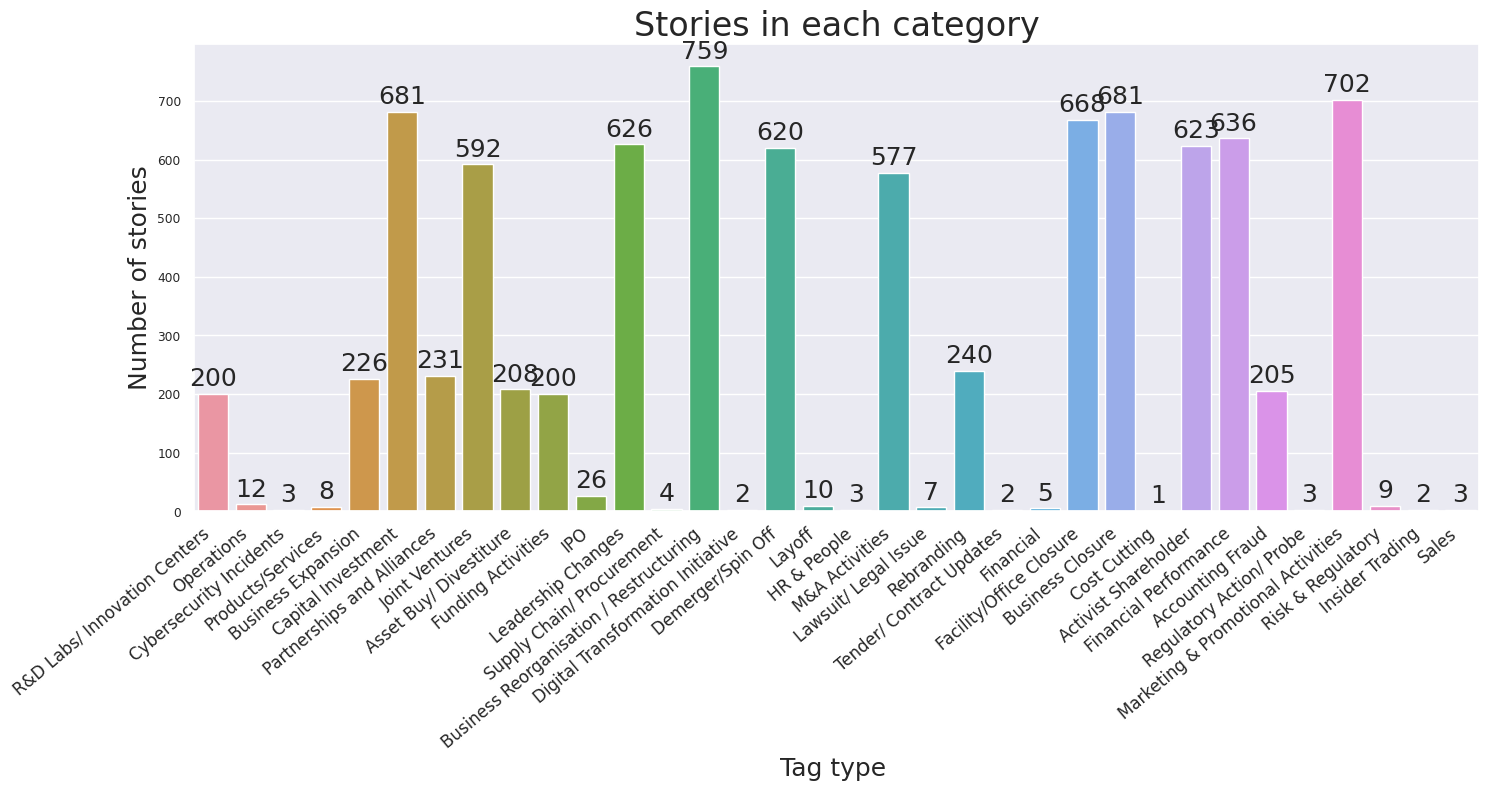

In [36]:
categories = list(tag_count.keys())
label_count = [tag_count[c] for c in categories]
categories = [id_name_map[c] for c in categories]
sns.set(font_scale = 0.8)
plt.figure(figsize=(15,8))
ax= sns.barplot(x=categories, y=label_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)

plt.title("Stories in each category", fontsize=24)
plt.ylabel('Number of stories', fontsize=18)
plt.xlabel('Tag type ', fontsize=18)
# fig = plt.figure()
# fig.autofmt_xdate()
#adding the text labels
rects = ax.patches
for rect, label in zip(rects, label_count):
    height = rect.get_height()
#     import ipdb; ipdb.set_trace()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, int(height), ha='center', va='bottom', fontsize=18)
plt.tight_layout()
plt.show()

In [37]:
categories

['R&D Labs/ Innovation Centers',
 'Operations',
 'Cybersecurity Incidents',
 'Products/Services',
 'Business Expansion',
 'Capital Investment',
 'Partnerships and Alliances',
 'Joint Ventures',
 'Asset Buy/ Divestiture',
 'Funding Activities',
 'IPO',
 'Leadership Changes',
 'Supply Chain/ Procurement',
 'Business Reorganisation / Restructuring',
 'Digital Transformation Initiative',
 'Demerger/Spin Off',
 'Layoff',
 'HR & People',
 'M&A Activities',
 'Lawsuit/ Legal Issue',
 'Rebranding',
 'Tender/ Contract Updates',
 'Financial',
 'Facility/Office Closure',
 'Business Closure',
 'Cost Cutting',
 'Activist Shareholder',
 'Financial Performance',
 'Accounting Fraud',
 'Regulatory Action/ Probe',
 'Marketing & Promotional Activities',
 'Risk & Regulatory',
 'Insider Trading',
 'Sales']

In [38]:
df_all = df

In [39]:
print(df_all.shape)

(7831, 10)


In [40]:
df_all = df_all[~df_all['s_tags'].apply(lambda x: len(x)<1)]

In [41]:
print(df_all.shape)

(7831, 10)


In [42]:
categories

['R&D Labs/ Innovation Centers',
 'Operations',
 'Cybersecurity Incidents',
 'Products/Services',
 'Business Expansion',
 'Capital Investment',
 'Partnerships and Alliances',
 'Joint Ventures',
 'Asset Buy/ Divestiture',
 'Funding Activities',
 'IPO',
 'Leadership Changes',
 'Supply Chain/ Procurement',
 'Business Reorganisation / Restructuring',
 'Digital Transformation Initiative',
 'Demerger/Spin Off',
 'Layoff',
 'HR & People',
 'M&A Activities',
 'Lawsuit/ Legal Issue',
 'Rebranding',
 'Tender/ Contract Updates',
 'Financial',
 'Facility/Office Closure',
 'Business Closure',
 'Cost Cutting',
 'Activist Shareholder',
 'Financial Performance',
 'Accounting Fraud',
 'Regulatory Action/ Probe',
 'Marketing & Promotional Activities',
 'Risk & Regulatory',
 'Insider Trading',
 'Sales']

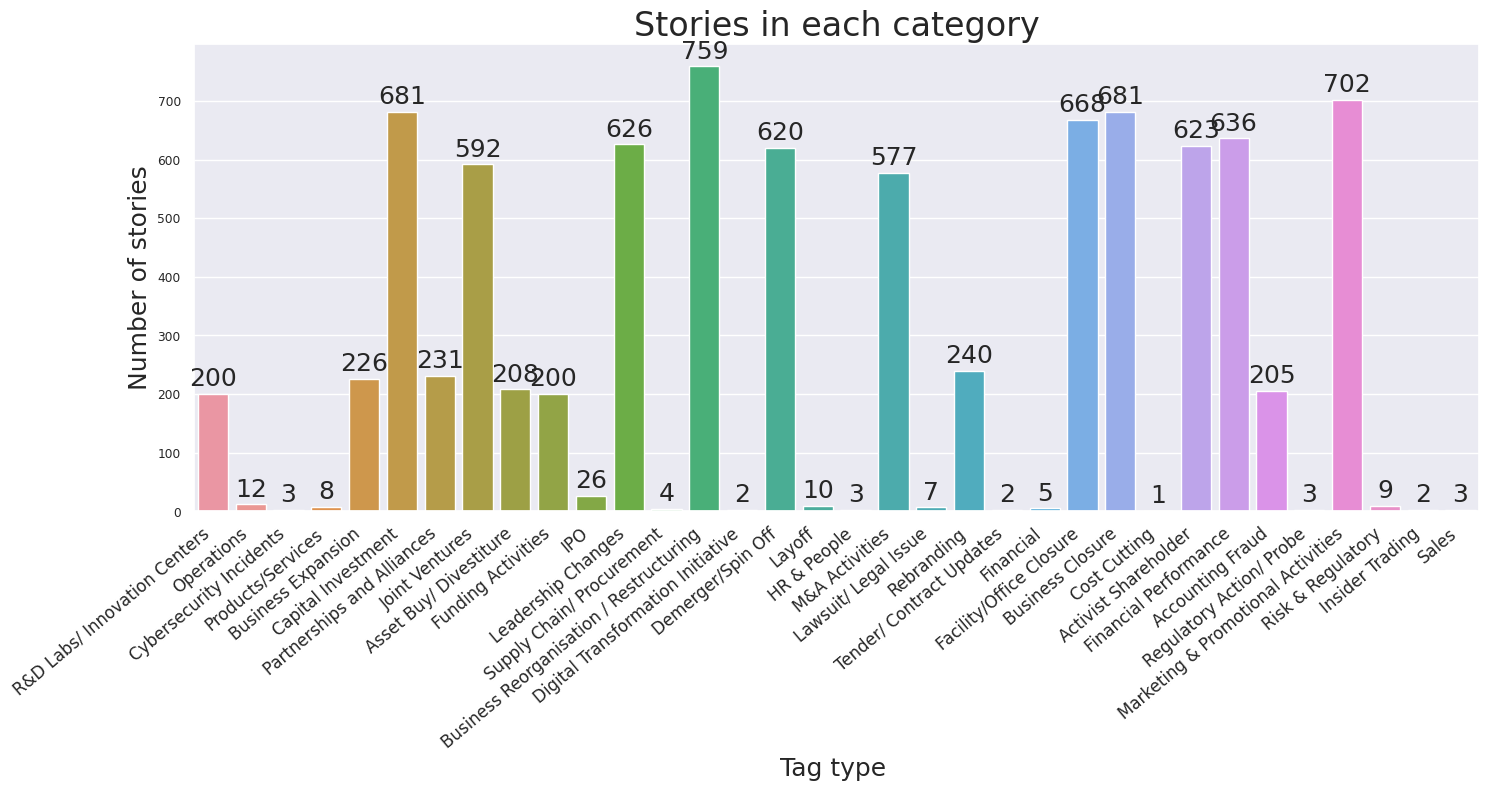

In [43]:
tag_list = df_all['s_tags'].to_list()
all_tag_list = list(chain.from_iterable(tag_list))
# all_tag_list = [int(i.strip()) for i in all_tag_list if i]
tag_count_all = collections.Counter(all_tag_list)
# del tag_count_all['N']
# del tag_count_all[' ']
# tag_count_all = tag_count = {k:v for k,v in tag_count_all.items() if k not in exclude_parent}
# del all_tag_list, tag_list
# print({id_name_map[t_id]:tag_count_all[t_id] for t_id in tag_count_all})
categories = list(tag_count_all.keys())
label_count = [tag_count_all[c] for c in categories]
categories = [id_name_map[c] for c in categories]
sns.set(font_scale = 0.8)
plt.figure(figsize=(15,8))
ax= sns.barplot(x=categories, y=label_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)

plt.title("Stories in each category", fontsize=24)
plt.ylabel('Number of stories', fontsize=18)
plt.xlabel('Tag type ', fontsize=18)
# fig = plt.figure()
# fig.autofmt_xdate()
#adding the text labels
rects = ax.patches
for rect, label in zip(rects, label_count):
    height = rect.get_height()
#     import ipdb; ipdb.set_trace()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, int(height), ha='center', va='bottom', fontsize=18)
plt.tight_layout()
plt.show()

In [44]:
tag_count_all

Counter({13: 200,
         15: 12,
         49: 3,
         31: 8,
         4: 226,
         11: 681,
         14: 231,
         12: 592,
         9: 208,
         10: 200,
         29: 26,
         7: 626,
         18: 4,
         5: 759,
         21: 2,
         6: 620,
         46: 10,
         44: 3,
         8: 577,
         52: 7,
         43: 240,
         38: 2,
         22: 5,
         20: 668,
         3: 681,
         17: 1,
         24: 623,
         27: 636,
         23: 205,
         54: 3,
         41: 702,
         48: 9,
         28: 2,
         37: 3})

In [45]:
all_tag_list

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 15,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 49,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 15,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 31,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,


In [46]:
tag_count_all

Counter({13: 200,
         15: 12,
         49: 3,
         31: 8,
         4: 226,
         11: 681,
         14: 231,
         12: 592,
         9: 208,
         10: 200,
         29: 26,
         7: 626,
         18: 4,
         5: 759,
         21: 2,
         6: 620,
         46: 10,
         44: 3,
         8: 577,
         52: 7,
         43: 240,
         38: 2,
         22: 5,
         20: 668,
         3: 681,
         17: 1,
         24: 623,
         27: 636,
         23: 205,
         54: 3,
         41: 702,
         48: 9,
         28: 2,
         37: 3})

In [47]:
id_name_map

{2: 'Strategy',
 3: 'Business Closure',
 4: 'Business Expansion',
 5: 'Business Reorganisation / Restructuring',
 6: 'Demerger/Spin Off',
 7: 'Leadership Changes',
 8: 'M&A Activities',
 9: 'Asset Buy/ Divestiture',
 10: 'Funding Activities',
 11: 'Capital Investment',
 12: 'Joint Ventures',
 14: 'Partnerships and Alliances',
 13: 'R&D Labs/ Innovation Centers',
 40: 'Marketing',
 41: 'Marketing & Promotional Activities',
 42: 'Awards & Recognitions',
 43: 'Rebranding',
 44: 'HR & People',
 45: 'Hirings (Non-Leadership)',
 46: 'Layoff',
 47: 'Employee Related Initiative',
 15: 'Operations',
 16: 'Operational Performance',
 17: 'Cost Cutting',
 18: 'Supply Chain/ Procurement',
 19: 'Operational Challenges',
 20: 'Facility/Office Closure',
 21: 'Digital Transformation Initiative',
 37: 'Sales',
 38: 'Tender/ Contract Updates',
 39: 'Pricing Changes',
 36: 'Product Discontinuation',
 31: 'Products/Services',
 32: 'Product Issues/ Recall',
 33: 'Analyst Recognition',
 34: 'Product/Service 

In [48]:
# df_small = df_all[df_all['s_tags'].apply(lambda x: False if x[0] in [395, 387] and len(x)==1 else True)]

In [49]:
df_small = df_all[df_all['s_tags'].apply(lambda x: len(x) > 0)]

In [50]:
df_small.shape

(7831, 10)

In [51]:
print(df_small.shape)
print(df_all.shape)

(7831, 10)
(7831, 10)


In [52]:
def show_count(df_count, field='s_tags'):
    tag_list = df_count[field].to_list()
    all_tag_list = list(chain.from_iterable(tag_list))
    tag_count_all = collections.Counter(all_tag_list)
    del all_tag_list, tag_list
    # print({id_name_map[t_id]:tag_count_all[t_id] for t_id in tag_count_all})
    categories = list(tag_count_all.keys())
    label_count = [tag_count_all[c] for c in categories]
    categories = [id_name_map[c] for c in categories]
    sns.set(font_scale = 0.8)
    plt.figure(figsize=(15,8))
    ax= sns.barplot(categories, label_count)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)

    plt.title("Stories in each category", fontsize=24)
    plt.ylabel('Number of stories', fontsize=18)
    plt.xlabel('Tag type ', fontsize=18)
    # fig = plt.figure()
    # fig.autofmt_xdate()
    #adding the text labels
    rects = ax.patches
    for rect, label in zip(rects, label_count):
        height = rect.get_height()
    #     import ipdb; ipdb.set_trace()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, int(height), ha='center', va='bottom', fontsize=18)
    plt.tight_layout()
    plt.show()

In [53]:
id_name_map

{2: 'Strategy',
 3: 'Business Closure',
 4: 'Business Expansion',
 5: 'Business Reorganisation / Restructuring',
 6: 'Demerger/Spin Off',
 7: 'Leadership Changes',
 8: 'M&A Activities',
 9: 'Asset Buy/ Divestiture',
 10: 'Funding Activities',
 11: 'Capital Investment',
 12: 'Joint Ventures',
 14: 'Partnerships and Alliances',
 13: 'R&D Labs/ Innovation Centers',
 40: 'Marketing',
 41: 'Marketing & Promotional Activities',
 42: 'Awards & Recognitions',
 43: 'Rebranding',
 44: 'HR & People',
 45: 'Hirings (Non-Leadership)',
 46: 'Layoff',
 47: 'Employee Related Initiative',
 15: 'Operations',
 16: 'Operational Performance',
 17: 'Cost Cutting',
 18: 'Supply Chain/ Procurement',
 19: 'Operational Challenges',
 20: 'Facility/Office Closure',
 21: 'Digital Transformation Initiative',
 37: 'Sales',
 38: 'Tender/ Contract Updates',
 39: 'Pricing Changes',
 36: 'Product Discontinuation',
 31: 'Products/Services',
 32: 'Product Issues/ Recall',
 33: 'Analyst Recognition',
 34: 'Product/Service 

In [54]:
tag_list = df_small['s_tags'].to_list()
all_tag_list = list(chain.from_iterable(tag_list))
tag_count = collections.Counter(all_tag_list)
del all_tag_list, tag_list

In [55]:
exclude_tags = [t for t, v in tag_count.items() if v < 1]

In [56]:
[tag_count.pop(ex_t) for ex_t in exclude_tags]

[]

In [57]:
tag_count

Counter({13: 200,
         15: 12,
         49: 3,
         31: 8,
         4: 226,
         11: 681,
         14: 231,
         12: 592,
         9: 208,
         10: 200,
         29: 26,
         7: 626,
         18: 4,
         5: 759,
         21: 2,
         6: 620,
         46: 10,
         44: 3,
         8: 577,
         52: 7,
         43: 240,
         38: 2,
         22: 5,
         20: 668,
         3: 681,
         17: 1,
         24: 623,
         27: 636,
         23: 205,
         54: 3,
         41: 702,
         48: 9,
         28: 2,
         37: 3})

In [58]:
df_small['s_tags'] = df_small['s_tags'].apply(lambda x: list(set(x).difference(exclude_tags)))

In [59]:
df_small['text'] = (df_small['titles']+". ")  + (df_small['body'])


In [60]:
df_small['text'] = df_small['text'].fillna(' ')

In [61]:
import re
def preprocess(text):
    text = re.sub('^\[(.*?)\]', '', text)   
    return text

In [62]:
u_tags = list(tag_count.keys())
df_final = df_small[~df_small['s_tags'].apply(lambda x: len(x) < 1)]

In [63]:
X_train, X_test, Y_train_tags, Y_test_tags = train_test_split(df_final, df_final['s_tags'], random_state=42,
                                                              test_size=0.99)
tag_test_count = collections.Counter(list(chain.from_iterable(Y_test_tags)))
tag_train_count = collections.Counter(list(chain.from_iterable(Y_train_tags)))

In [64]:
len(X_test["text"].to_list())

7753

In [65]:
# binarizer = MultiLabelBinarizer()
# binarizer.fit([u_tags])
# Y_train_b = binarizer.transform(Y_train_tags.to_list())

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
class FeatureSelector( BaseEstimator, TransformerMixin ):
        #Class Constructor 
    def __init__( self):
        pass
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    
    def preprocess(self, text):
        text = re.sub('^\[(.*?)\]', '', text)   
        return text
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return list(map(self.preprocess, X))

In [14]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import AutoTokenizer
import torch
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained("be-8-jan-sem_eval-english/")
trainer = Trainer(model=model)
tokenizer = AutoTokenizer.from_pretrained("be-8-jan-sem_eval-english/")

def final_prediction(data):
    final_predicted_labels = []
    for txt in data:
        import gc
        gc.collect()
        txt = " ".join(txt.split()[:500])
        encoding = tokenizer(txt, return_tensors="pt",truncation=True)
        encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
#         torch.cuda.empty_cache()
        outputs = trainer.model(**encoding)
        logits = outputs.logits
        # apply sigmoid + threshold
        sigmoid = torch.nn.Sigmoid()
        
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.7)] = 1
        # turn predicted id's into actual label names
        predicted_labels = [model.config.id2label[idx] for idx, label in enumerate(predictions) if label > 0.7]
        print(predicted_labels)
        final_predicted_labels.append(predicted_labels)
        import gc
        gc.collect()
    return final_predicted_labels


# Fitting the training data into the pipeline to train the model

In [15]:
import pandas as pd
X_NEW = pd.read_csv('story_data-1.csv')

In [16]:
X_NEW['text'] = X_NEW['title'] + X_NEW['body']

In [17]:
X_NEW['text']

0     Harbor Scenic Drive Temporary Closures Announc...
1     Trucking Giant Yellow Ceases Operations<p>Truc...
2     WestRock Announces Plans to Close Tacoma, Wash...
3     Bankrupt Yellow Shutting Down: ReportYellow Co...
4     Port Erin business announces physical shop clo...
                            ...                        
86    ExecOnline Collaborates with the Amazon Web Se...
87    AAON Receives AMCA Accreditation for Norman As...
88    HMG Healthcare Says Data Breach Impacts 40 Fac...
89    Transformative Healthcare experiences large da...
90    HMG Healthcare disclosed a data breachHMG Heal...
Name: text, Length: 91, dtype: object

# Getting the Prediction for test data

In [18]:
import numpy as np
from datetime import datetime
3175774,# %%timeit
start = datetime.now()
torch.cuda.empty_cache()
predict_tags =final_prediction(X_NEW['text'])
print((datetime.now()-start).total_seconds())

['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['3']
['50']
['55']
['55']
['55']
['55']
['55']
['55']
['55']
['55']
['55']
['13']
['13']
['13']
['55']
['29']
['29']
['29']
['55']
['55']
['55']
['13']
['50']
['29']
['50']
['50']
['50']
['55']
['55']
['55']
['55']
['29']
['50']
['55']
['50']
['29']
['29']
['13']
['55']
['29']
['13']
['29']
['29']
['29']
['55']
['55']
['50']
['29']
['29']
['29']
['13']
['29']
['50']
['50']
['13']
['50']
['50']
['50']
['50']
['50']
['50']
['50']
['50']
['50']
['50']
['29']
['29']
['29']
['13']
['13']
['13']
['13']
['13']
['13']
['13']
['50']
['50']
['50']
58.266141


['8', '2']
['14', '2']
['47']
['12']
['27']
['5', '6', '2']
['7']
['41']
['27', '22']
['27']
['7']
['20']
[]
['3', '20']
['27']
[]
['5', '6', '2']
['7']
['53']
['27']
['3', '20', '2', '15']
['5', '6', '2']
['7']
['3', '20']
['54']
['14']
['13']
['12']
['7']
['52']
[]
['27', '22']
['15']
[]
['7']
['11']
['2']
['20']
['41', '40']
['7']
['11']
['41']
[]
[]
['34']
['5', '2']
[]
['22', '30']
['13']
['3', '20']
[]
['8', '2']
['3', '20']
['7']
['27']
['14']
['8']
['14']
['41']
['27']
['6', '2']
['4', '2']
['20']
[]
[]
['21']
['27']
['7']
['13', '2']
['41']
['7']
['11']
['6', '2']
['8', '2']
['12']
['24']
['11']
['10']
['27']
['41']
['20']
['7']
['9']
[]
[]
['7']
['5', '2']
['4']
['3', '20', '2', '15']
['3', '20']
[]
['41']
['4']
['41']
['43', '40']
['20']
['7']
['39']
['6', '2']
['5', '6', '2']
['10']
['24']
['12']
['11']
['26', '22']
['27']
['43']
['8']
['3', '20', '15']
['27']
['11']
['12']
['42']
['41']
['9', '2']
['8', '2']
['12']
['27', '22']
['5']
['24']
['8']
['7']
[]
['47']
[]
['49', 

['27']
['27']
[]
['23']
[]
['12', '2']
['8']
['41']
['53', '12']
[]
[]
[]
['14']
['11', '2']
['3', '20', '2', '15']
['34']
[]
['27']
['16']
['3', '20', '2']
[]
['49']
['7']
['4']
['5', '6', '2']
['41']
[]
[]
['5', '6', '2']
['10']
['54']
['4', '2']
['39']
['7']
['3', '20', '2', '15']
['12']
['43', '40']
['14', '2']
['7']
['27', '22']
[]
['41', '40']
['41']
['11']
['43', '40']
['12']
[]
['39']
['52', '48', '22', '24']
['41']
['4']
[]
['41']
['4', '2']
['2']
[]
['41']
['7']
[]
['41', '40']
['23']
['22', '2']
[]
[]
[]
['11']
[]
[]
['44']
['41']
['27']
['11']
['27']
['12']
['27']
['24']
['3', '20']
['7']
[]
['12']
['41']
['39']
['11', '2']
['41']
['41']
[]
['3', '20', '2', '15']
['27']
['8', '2']
['43']
[]
[]
['11', '2']
['27']
['5', '6', '2']
['52']
['53']
['34']
['53']
['27']
['9']
['9']
[]
['2']
['32']
['26', '22']
[]
[]
['41']
['6', '2']
['7']
['39']
['7']
['7']
['34']
['41']
['41']
['8']
[]
['12', '2']
['53']
['13', '12', '2']
['19']
['3', '20', '15']
['7']
['43', '40']
['39']
['14']


['27']
['35']
['12']
['43', '40']
['43']
['3', '20']
['27']
['27']
[]
[]
['41', '40']
[]
['12']
[]
['14']
['39']
['43', '40']
['11']
['8']
[]
['14', '2']
['21']
['11']
['7']
['41']
['8']
['7']
['4']
['19']
['4']
['3', '20', '15']
['29']
['8']
['8']
['12']
['27']
['5', '2']
[]
['47']
['11']
['11', '2']
['3', '20']
[]
['7']
['41']
[]
['41', '40']
[]
['41', '40']
['13']
['27']
[]
['41']
[]
['7']
['41']
['8', '2']
['3', '20', '2', '15']
['20']
['41']
[]
['12', '2']
['27', '22']
['5', '2']
['14', '2']
['20']
['7']
['26', '22']
['10']
['8']
['12']
['9']
['8', '2']
[]
['9', '2']
['3', '20', '2']
['22', '24']
['24']
['10']
['27']
['6']
['4']
[]
['27']
['3', '20', '15']
['12', '2']
['11', '2']
['41', '40']
['7']
['6', '2']
['41', '40']
['5', '6', '2']
[]
['41']
['8']
['8', '2']
['4']
['27']
['11', '2']
['9']
['22', '24']
['24']
['41', '40']
['54']
['11']
['39']
['14']
['6', '2']
['54', '48']
[]
['24']
['12', '2']
['8', '2']
['22']
['12']
['7']
['5', '2']
['5', '6', '2']
['3', '20', '2', '15']
[

['3', '20']
['20']
['14']
['44']
['45', '44']
['41']
['20']
['41', '40']
['29']
[]
['5', '6', '2']
['6', '2']
[]
[]
['14']
['27']
['8']
['52']
['41']
[]
['42']
['41']
[]
['12']
['5', '2']
['3', '20', '15']
['5']
['24']
['23']
[]
['24']
['7']
['4', '2']
['14']
['12']
['12', '2']
['3', '20']
['10']
['53']
[]
['27']
['11']
['6', '2']
['7']
['24']
['27', '12']
['10']
['11']
['3', '20']
[]
['12']
['11']
['12']
['20']
['12']
['11']
['27']
['41']
['14']
['53', '48']
[]
['5']
['27', '22']
['14']
['11']
[]
['27']
['41']
['3', '20', '15']
['8']
['9']
['34']
['7']
['53']
[]
['8', '52']
['34', '5']
[]
['43']
['3', '20', '2', '15']
['14']
['14']
['7']
['26', '22']
['14']
['34']
['27']
['21']
['5']
[]
['4']
['8']
['43']
['24']
['8', '2']
[]
['11']
[]
['7']
['41', '40']
['4']
['41']
[]
['4']
['4']
[]
['8', '2']
['41']
['7']
[]
['40']
['11']
['43']
['7']
['11', '2']
['5', '2']
['7']
['14']
['41']
['8']
[]
['20']
['20', '15']
['10']
['38']
['41']
['27']
['10']
['41', '40']
['27']
['5', '6', '2']
['39']

In [19]:
X_NEW['predicted_tags'] = predict_tags

In [21]:
X_NEW.to_excel("manual_data_prediction.xlsx")

In [70]:
X_test['text']

1142    Hogan named ABAC Vice President of Enrollment ...
4577    Tesco Express responds to rumours Swindon stor...
2596    Banco Santander prepares to divest €5B in bad ...
1679    Flowserve Corporation Jobs. Company Overview:<...
4970    Nico Demers: A writer, not a fighter. Everyone...
                              ...                        
4024    Joint Establishment of a Second Corporate Vent...
775     FTX/Alameda Continues Major Asset Movements, T...
2560    CM inaugurates work for 2 bridges in Madurai -...
7609    How do I rename image in OpenStack using comma...
1480    Spero Therapeutics Appoints Esther Rajavelu as...
Name: text, Length: 7753, dtype: object

In [71]:
predict_tags

[['7'],
 ['3', '20', '2', '15'],
 [],
 [],
 ['6', '2'],
 [],
 [],
 ['8'],
 [],
 ['8'],
 ['8', '2'],
 ['42'],
 ['4', '2'],
 ['7'],
 ['41'],
 ['24'],
 ['12'],
 ['27'],
 ['12'],
 ['4'],
 [],
 ['14'],
 [],
 ['7'],
 [],
 ['11'],
 [],
 [],
 ['27'],
 ['27', '22'],
 ['6', '2'],
 ['53', '23', '48', '22', '51'],
 ['24'],
 ['20'],
 ['24'],
 ['45'],
 ['15'],
 ['26'],
 ['41'],
 ['2'],
 ['12'],
 ['39', '37'],
 ['11', '2'],
 ['5'],
 ['27'],
 ['12'],
 ['8'],
 ['5'],
 ['7'],
 ['53'],
 [],
 ['42'],
 ['27'],
 [],
 ['9'],
 [],
 ['20', '15'],
 ['41'],
 ['3', '20'],
 [],
 ['11'],
 ['41'],
 ['7'],
 [],
 ['14', '2'],
 ['26', '22'],
 ['41'],
 ['49'],
 ['41'],
 ['41'],
 ['20'],
 ['41'],
 ['8', '2'],
 ['5', '6', '2'],
 ['41'],
 [],
 ['8'],
 ['27'],
 [],
 ['54'],
 ['11'],
 ['27'],
 ['27'],
 ['27'],
 ['41'],
 ['8'],
 ['22', '24'],
 ['5'],
 ['5', '6', '2'],
 [],
 ['41', '40'],
 ['23', '48', '22', '51'],
 ['3', '20'],
 ['34'],
 ['12'],
 ['12'],
 ['34'],
 ['14'],
 ['9'],
 ['27'],
 ['12'],
 [],
 ['4'],
 ['27'],
 [],
 

In [72]:
new_predicted_tags = converted_data = [[int(value) for value in inner_list] if inner_list else [] for inner_list in predict_tags]

In [73]:
new_predicted_tags

[[7],
 [3, 20, 2, 15],
 [],
 [],
 [6, 2],
 [],
 [],
 [8],
 [],
 [8],
 [8, 2],
 [42],
 [4, 2],
 [7],
 [41],
 [24],
 [12],
 [27],
 [12],
 [4],
 [],
 [14],
 [],
 [7],
 [],
 [11],
 [],
 [],
 [27],
 [27, 22],
 [6, 2],
 [53, 23, 48, 22, 51],
 [24],
 [20],
 [24],
 [45],
 [15],
 [26],
 [41],
 [2],
 [12],
 [39, 37],
 [11, 2],
 [5],
 [27],
 [12],
 [8],
 [5],
 [7],
 [53],
 [],
 [42],
 [27],
 [],
 [9],
 [],
 [20, 15],
 [41],
 [3, 20],
 [],
 [11],
 [41],
 [7],
 [],
 [14, 2],
 [26, 22],
 [41],
 [49],
 [41],
 [41],
 [20],
 [41],
 [8, 2],
 [5, 6, 2],
 [41],
 [],
 [8],
 [27],
 [],
 [54],
 [11],
 [27],
 [27],
 [27],
 [41],
 [8],
 [22, 24],
 [5],
 [5, 6, 2],
 [],
 [41, 40],
 [23, 48, 22, 51],
 [3, 20],
 [34],
 [12],
 [12],
 [34],
 [14],
 [9],
 [27],
 [12],
 [],
 [4],
 [27],
 [],
 [],
 [8],
 [27],
 [],
 [14],
 [7],
 [3, 20, 2, 15],
 [45, 44],
 [5],
 [43, 40],
 [5, 6, 2],
 [8],
 [7],
 [7],
 [8, 2],
 [3, 20],
 [],
 [14, 12],
 [],
 [41],
 [9],
 [12],
 [8],
 [11],
 [12, 2],
 [],
 [3, 20, 15],
 [23],
 [3, 20, 

# Function to get the overall report of ml model

In [74]:
def classification_report(predicted_items, true_items, labels, tag_info,train_count, test_count, total_count):
    """This function returns label wise f1 scores.
    true_positive: Correctly predicted
    false positive: Incorectly predicted
    false negative: Missed
    """
    scores = collections.defaultdict(lambda: collections.defaultdict(float))

#     tag_info = self.extract_tag_info()

    for label in labels:
        scores[label]['id'] = label
        scores[label]['name'] = tag_info[label]
#         scores[label]['name'] = tag_info[label].get('name', '')
#         scores[label]['bucket_name'] = tag_info[label].get('bucket', '')
        scores[label]['true_positive'] = 0
        scores[label]['false_positive'] = 0
        scores[label]['false_negative'] = 0
        scores[label]['train_count'] = train_count[label]
        scores[label]['test_count'] = test_count[label]
        scores[label]['total_count'] = total_count[label]
        scores[label]['f1_score'] = 0

    for i in range(len(predicted_items)):
        for pred_item in predicted_items[i]:
            if pred_item in true_items[i]:
                scores[pred_item]['true_positive'] = (
                        scores[pred_item]['true_positive'] + 1
                )

            if pred_item not in true_items[i]:
                scores[pred_item]['false_positive'] = (
                        scores[pred_item]['false_positive'] + 1
                )

        for true_item in true_items[i]:
            if true_item not in predicted_items[i]:
                scores[true_item]['false_negative'] = (
                        scores[true_item]['false_negative'] + 1
                )

    for label in labels:
        if scores[label]['true_positive'] or scores[label]['false_positive'] or scores[label]['false_negative']:
            if scores[label]['true_positive'] or scores[label]['false_negative']:
                scores[label]['recall'] = round(
                    scores[label]['true_positive'] / float(
                        scores[label]['true_positive'] +
                        scores[label]['false_negative']), 4
                )
            if scores[label]['true_positive'] or scores[label]['false_positive']:
                scores[label]['Precision'] = round(
                    scores[label]['true_positive'] / float(
                        scores[label]['true_positive'] +
                        scores[label]['false_positive']), 4
                )

            scores[label]['f1_score'] = round(
                2 * scores[label]['true_positive'] / float(
                    2 * scores[label]['true_positive'] +
                    scores[label]['false_positive'] +
                    scores[label]['false_negative']), 4
            )

    return scores


In [75]:
actual_train_tags = [x if x not in [[' '], ['N']] else  [] for x in Y_test_tags.to_list()]

In [76]:
# len(u_tags)

In [77]:
# u_tags = list(tag_count.keys())

In [78]:
# u_tags = [x  for x in u_tags if x not in [' ', 'N']]

In [79]:
len(new_predicted_tags)

7753

In [80]:
X_test

,Unnamed: 0,Title,Intro,Business Events,URL,titles,body,correct BE,UUID,s_tags,text
1142,1142,Hogan named ABAC Vice President of Enrollment ...,Your Local Sinus Experts are now located in th...,Leadership Changes,https://www.douglasnow.com/index.php/news/item...,Hogan named ABAC Vice President of Enrollment ...,Your Local Sinus Experts are now located in th...,"[2, 7]",1-82-231031-53632402,[7],Hogan named ABAC Vice President of Enrollment ...
4577,4577,Tesco Express responds to rumours Swindon stor...,Rumours that Tesco Express at The Parade could...,Facility/Office Closure | Business Closure,https://www.swindonadvertiser.co.uk/news/23881...,Tesco Express responds to rumours Swindon stor...,Rumours that Tesco Express at The Parade could...,"[2, 3, 20, 15]",1-82-231026-52480249,"[3, 20]",Tesco Express responds to rumours Swindon stor...
2596,2596,Banco Santander prepares to divest €5B in bad ...,"Published Oct 31, 2023 02:50 © Reuters. SAN +3...",Capital Investment,https://au.investing.com/news/stock-market-new...,Banco Santander prepares to divest €5B in bad ...,"Published Oct 31, 2023 02:50<br><br>© Reuters....","[2, 11]",1-82-231030-53551543,[11],Banco Santander prepares to divest €5B in bad ...
1679,1679,Flowserve Corporation Jobs,"Company Overview: If a culture of excellence, ...",Business Reorganisation / Restructuring,https://flowservecareers.com/houston-tx/decarb...,Flowserve Corporation Jobs,Company Overview:<br><br>If a culture of excel...,[5],1-82-231031-53686643,[5],Flowserve Corporation Jobs. Company Overview:<...
4970,4970,"Nico Demers: A writer, not a fighter","Everyone has a passion, but not everyone may r...",Demerger/Spin Off,https://thedailyaztec.com/115252/showcase/nico...,"Nico Demers: A writer, not a fighter","Everyone has a passion, but not everyone may r...","[2, 6]",1-82-231026-52257540,[6],"Nico Demers: A writer, not a fighter. Everyone..."
...,...,...,...,...,...,...,...,...,...,...,...
4024,4024,Joint Establishment of a Second Corporate Vent...,Nikon Corporation (Nikon) today announced that...,Joint Ventures,https://www.webwire.com/ViewPressRel.asp?aId=3...,Joint Establishment of a Second Corporate Vent...,Nikon Corporation (Nikon) today announced that...,"[2, 12]",1-82-231101-54309865,[12],Joint Establishment of a Second Corporate Vent...
775,775,"FTX/Alameda Continues Major Asset Movements, T...",Blockchain analytical firm LookOnChain has obs...,Asset Buy/ Divestiture,https://www.binance.com/en/feed/post/2023-10-3...,"FTX/Alameda Continues Major Asset Movements, T...",Blockchain analytical firm LookOnChain has obs...,"[9, 2]",1-82-231031-53707231,[9],"FTX/Alameda Continues Major Asset Movements, T..."
2560,2560,CM inaugurates work for 2 bridges in Madurai -...,Chief Minister MK Stalin flagged off the const...,Capital Investment,https://newstodaynet.com/2023/10/31/cm-inaugur...,CM inaugurates work for 2 bridges in Madurai -...,Chief Minister MK Stalin flagged off the const...,"[2, 11]",1-82-231031-53729640,[11],CM inaugurates work for 2 bridges in Madurai -...
7609,7609,How do I rename image in OpenStack using comma...,How do I rename image in OpenStack using comma...,Rebranding,https://www.trendradars.com/article-5259979-ho...,How do I rename image in OpenStack using comma...,<p>How do I rename image in OpenStack using co...,"[40, 43]",1-82-231102-54596795,[43],How do I rename image in OpenStack using comma...


In [81]:
Y_test_tags.to_list()

[[7],
 [3, 20],
 [11],
 [5],
 [6],
 [6],
 [27],
 [8],
 [5],
 [8],
 [8],
 [43],
 [11, 4],
 [7],
 [41],
 [24],
 [12],
 [27],
 [8],
 [4],
 [41],
 [14],
 [14],
 [24],
 [13],
 [11],
 [24],
 [6],
 [27],
 [27],
 [5, 6],
 [23],
 [24],
 [3, 20],
 [24],
 [12],
 [5, 6],
 [8],
 [7],
 [24],
 [12],
 [11],
 [11],
 [5],
 [5],
 [12],
 [8],
 [5],
 [7],
 [4],
 [4],
 [41],
 [27],
 [12],
 [9],
 [24],
 [3, 20],
 [41],
 [3, 20],
 [27],
 [11],
 [13],
 [14],
 [6],
 [14],
 [5],
 [41],
 [49, 13],
 [41],
 [41],
 [3, 20],
 [41],
 [8],
 [5, 6],
 [41],
 [11],
 [8],
 [27],
 [3, 20],
 [23],
 [11],
 [27],
 [27],
 [27],
 [6],
 [8],
 [7],
 [5],
 [6],
 [24],
 [41],
 [23],
 [3, 20],
 [5],
 [12],
 [14],
 [43],
 [14],
 [9],
 [27],
 [12],
 [41],
 [4],
 [27],
 [41],
 [3, 20],
 [8],
 [27],
 [23],
 [14],
 [7],
 [3, 20],
 [11],
 [5],
 [43],
 [6],
 [8],
 [7],
 [7],
 [8],
 [3, 20],
 [7],
 [14],
 [12],
 [41],
 [9],
 [12],
 [8],
 [11],
 [12],
 [13],
 [3, 20],
 [23],
 [3, 20],
 [14],
 [41],
 [8],
 [12],
 [9],
 [10],
 [8],
 [13],
 [11]

In [82]:
scores = classification_report(predicted_items=new_predicted_tags, true_items=Y_test_tags.to_list(), labels=u_tags, tag_info=id_name_map,
                              train_count=tag_train_count, test_count=tag_test_count, total_count=tag_count)

In [83]:
df_score = pd.DataFrame.from_dict(scores.values())

In [84]:
df_score

,id,name,true_positive,false_positive,false_negative,train_count,test_count,total_count,f1_score,recall,Precision
0,13.0,R&D Labs/ Innovation Centers,32.0,59.0,166.0,2.0,198.0,200.0,0.2215,0.1616,0.3516
1,15.0,Operations,1.0,269.0,11.0,0.0,12.0,12.0,0.0071,0.0833,0.0037
2,49.0,Cybersecurity Incidents,3.0,14.0,0.0,0.0,3.0,3.0,0.3000,1.0000,0.1765
3,31.0,Products/Services,0.0,17.0,8.0,0.0,8.0,8.0,0.0000,0.0000,0.0000
4,4.0,Business Expansion,121.0,124.0,104.0,1.0,225.0,226.0,0.5149,0.5378,0.4939
5,11.0,Capital Investment,390.0,62.0,279.0,12.0,669.0,681.0,0.6958,0.5830,0.8628
6,14.0,Partnerships and Alliances,164.0,123.0,64.0,3.0,228.0,231.0,0.6369,0.7193,0.5714
7,12.0,Joint Ventures,439.0,34.0,149.0,4.0,588.0,592.0,0.8275,0.7466,0.9281
8,9.0,Asset Buy/ Divestiture,122.0,72.0,84.0,2.0,206.0,208.0,0.6100,0.5922,0.6289
9,10.0,Funding Activities,108.0,27.0,90.0,2.0,198.0,200.0,0.6486,0.5455,0.8000
